In [ ]:
# Active learning to determine optimal compositions of a cell-free reaction
# Data can come from plate reader/microfluidics experiments
# or be generated in-silico for demonstration purposes

# The in silico model is a genome-scale metabolic model from Horvath et al. 2020
# paper: https://doi.org/10.1016/j.mec.2019.e00113
# github: https://github.com/varnerlab/Kinetic-CFPS-Model-Publication-Code

# The active learning framework is adapted from Borkowski et al. 2020 
# paper: https://doi.org/10.1101/751669.
# github: https://github.com/brsynth/active_learning_cell_free 

# by N. Laohakunakorn (nadanai.laohakunakorn@ed.ac.uk)
# April 2021

In [ ]:
using Flux
using Flux.Optimise: update!
using Flux: Chain, Dense, Dropout, @epochs
using CUDA
using Base: @kwdef
using Statistics, LsqFit, DataFrames, CSV, ProgressBars, Serialization
using Plots 
using Sundials
using Random; rng = MersenneTwister(1234);
include("./scripts/AL_helpers.jl");
include("./scripts/AL_solver.jl");

First initialise directories, hyperparameters, and GPU if available.

In [ ]:
CUDA.versioninfo()

In [14]:
# Directories
OUTPUT = "./models/" # directory where models are saved
INPUT = "./data/" # directory where compositional/output data are saved

# Hyperparameters
@kwdef mutable struct Args
    η::Float64 = 0.001       # learning rate
    batchsize::Int = 99    # batch size
    epochs::Int = 500     # number of epochs
    use_cuda::Bool = true   # use gpu (if cuda available)
end
args = Args()

# GPU 
if CUDA.functional() && args.use_cuda
    @info "Training on CUDA GPU"
    CUDA.allowscalar(false)
    device = gpu
else
    @info "Training on CPU"
    device = cpu
end

┌ Info: Training on CPU
└ @ Main In[14]:20


cpu (generic function with 1 method)

### 1. Set up allowed compositions, and random initial grid

Here we choose 8 species which correspond to components of the energy solution. Their maximum allowed concentrations are chosen to be 2 times the starting concentrations in the original Varner model. Each species is associated with an index, defined in the model's DataFiles.jl. We generate the initial training grid of 99 compositions, which consists of 'one-hot' and 'one-cold' settings followed by random compositions. The grid generation is such that no compositions ever repeat throughout the entire learning process.

In [15]:
# 1. Set up compositions to vary, and allowed concentrations
NCOMPS = 8
ntp_c_max = 1.5
aa_nglu_c_max = 3.0 
nad_c_max = 2.94
thf_c_max = 1.24
coa_c_max = 1.24
pga_c_max = 4.26
glu_c_max = 340
trna_c_max = 3.2
ALLOWEDCONCS = [0.1, 0.3, 0.5, 1]
maxcomps = [ntp_c_max,aa_nglu_c_max,nad_c_max,thf_c_max,coa_c_max,pga_c_max,glu_c_max,trna_c_max]
speciesidx = [106,118,145,38,10,7,136,99]; # relevent indices, defined in DataFiles.jl

In [16]:
# Generate initial grid, save, and have a look at it
@info "Generating initial grid"
gridsize = 99 # Number of compositions to consider
initialgrid = generate_initial_grid(gridsize,NCOMPS,ALLOWEDCONCS)
CSV.write(INPUT*"initial_grid.csv", DataFrame(initialgrid)); 
heatmap(initialgrid, c=:bluegreenyellow,yaxis="composition",axis="ID")

┌ Info: Generating initial grid
└ @ Main In[16]:2


LoadError: [91mArgumentError: `DataFrame` constructor from a `Matrix` requires passing :auto as a second argument to automatically generate column names: `DataFrame(matrix, :auto)`[39m

### 2. Step through one round of active learning

In [17]:
# We step through one round. For 10 rounds, see the script AL_10rounds.jl.
# First define file names.

# Filenames
COMPDATA = ["initial_grid","round1_proposed"]
FLUORDATA = ["round1_fluor"];


#### 1. Read input composition data 

This is the grid we generated earlier.

┌ Warning: `type` keyword argument is deprecated; a single type can be passed to `types` instead
└ @ CSV /opt/julia/packages/CSV/jFiCn/src/context.jl:278
┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1278


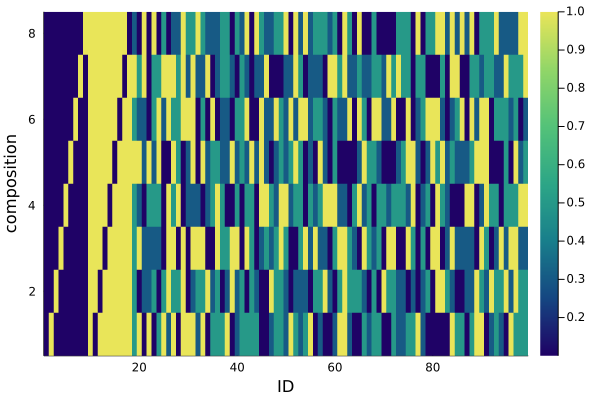

In [18]:
round = 1 # This can be put into a for loop

ROUND = "round"*string(round)
# Read composition data
df = CSV.read(INPUT*COMPDATA[round]*".csv", DataFrame, type=Float32);
x_data = Matrix(df); 
# size(x_data) # should be (8,99)
pl = heatmap(x_data, c=:bluegreenyellow,yaxis="composition",axis="ID")
savefig(OUTPUT*COMPDATA[round]*".pdf")
pl # show plot

#### 2. Generate training data

In [19]:
# 1. Generate training data for this round
# This takes a long time as all compositions have to be simulated
# Skip to the next cell if you don't want to re-run the simulation,
# as the data is already available

@info "1. Generating training data"
# Solve Varner model for initial composition array
cat_c = []
for j in ProgressBar(1:size(x_data,2))
    compositions = x_data[:,j]
    cat = solvemodel(compositions,maxcomps,speciesidx)
    push!(cat_c,cat)
end
CSV.write(INPUT*FLUORDATA[round]*".csv", DataFrame(reshape(cat_c,(size(x_data,2),1)))); 
df = CSV.read(INPUT*FLUORDATA[round]*".csv", DataFrame, type=Float32);
y_data = reshape(Array(df),gridsize); #/0.018560623281234926 # normalise to original maximum if required
# size(y_data) # should be (99,)
pl = heatmap(reshape(y_data,1,length(y_data)), c=:bluegreenyellow,yaxis="fluorescence",axis="ID")
savefig(OUTPUT*FLUORDATA[round]*".pdf")
pl # show plot

┌ Info: 1. Generating training data
└ @ Main In[19]:6
0.0%┣                                                ┫ 0/99 [00:00<00:-5, 0s/it]
┌ Info: Solving 101
└ @ Main /home/jovyan/scripts/AL_solver.jl:62
1.0%┣▍                                          ┫ 1/99 [00:26<Inf:Inf, InfGs/it]
┌ Info: Solving 101
└ @ Main /home/jovyan/scripts/AL_solver.jl:62
2.0%┣█                                           ┫ 2/99 [00:45<01:12:08, 45s/it]
┌ Info: Solving 101
└ @ Main /home/jovyan/scripts/AL_solver.jl:62
3.0%┣█▍                                             ┫ 3/99 [01:04<51:02, 32s/it]
┌ Info: Solving 101
└ @ Main /home/jovyan/scripts/AL_solver.jl:62
4.0%┣██                                             ┫ 4/99 [01:23<44:02, 28s/it]
┌ Info: Solving 101
└ @ Main /home/jovyan/scripts/AL_solver.jl:62
5.1%┣██▍                                            ┫ 5/99 [01:43<40:13, 26s/it]
┌ Info: Solving 101
└ @ Main /home/jovyan/scripts/AL_solver.jl:62
6.1%┣██▉                                            ┫ 6/99 [02:0

56.6%┣█████████████████████████▌                   ┫ 56/99 [18:41<14:37, 20s/it]
┌ Info: Solving 101
└ @ Main /home/jovyan/scripts/AL_solver.jl:62
57.6%┣██████████████████████████                   ┫ 57/99 [19:03<14:17, 20s/it]
┌ Info: Solving 101
└ @ Main /home/jovyan/scripts/AL_solver.jl:62
58.6%┣██████████████████████████▍                  ┫ 58/99 [19:24<13:57, 20s/it]
┌ Info: Solving 101
└ @ Main /home/jovyan/scripts/AL_solver.jl:62
59.6%┣██████████████████████████▉                  ┫ 59/99 [19:47<13:38, 20s/it]
┌ Info: Solving 101
└ @ Main /home/jovyan/scripts/AL_solver.jl:62
60.6%┣███████████████████████████▎                 ┫ 60/99 [20:07<13:18, 20s/it]
┌ Info: Solving 101
└ @ Main /home/jovyan/scripts/AL_solver.jl:62
61.6%┣███████████████████████████▊                 ┫ 61/99 [20:28<12:58, 20s/it]
┌ Info: Solving 101
└ @ Main /home/jovyan/scripts/AL_solver.jl:62
62.6%┣████████████████████████████▏                ┫ 62/99 [20:50<12:38, 20s/it]
┌ Info: Solving 101
└ @ Main /home/jo

LoadError: [91mArgumentError: `DataFrame` constructor from a `Matrix` requires passing :auto as a second argument to automatically generate column names: `DataFrame(matrix, :auto)`[39m

┌ Warning: `type` keyword argument is deprecated; a single type can be passed to `types` instead
└ @ CSV /opt/julia/packages/CSV/jFiCn/src/context.jl:278


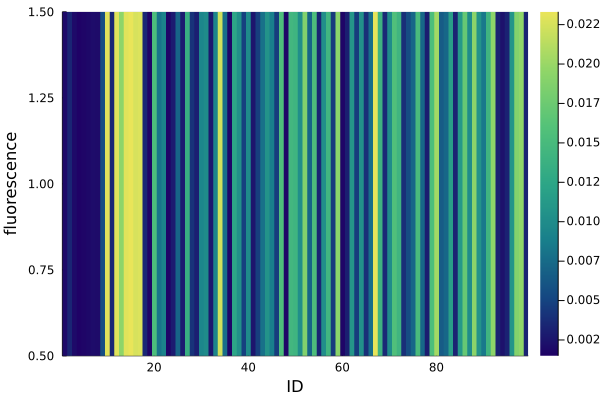

In [20]:
# Read in the data again and look at it
df = CSV.read(INPUT*FLUORDATA[round]*".csv", DataFrame, type=Float32);
y_data = reshape(Array(df),gridsize); #/0.018560623281234926 # normalise to original maximum if required
pl = heatmap(reshape(y_data,1,length(y_data)), c=:bluegreenyellow,yaxis="fluorescence",axis="ID")
pl # show plot

#### 3. Train ensemble MLP on this data
We train 250 MLPs on the data, and select the best 25, to produce our final ensemble MLP model. The MLP structure is defined internally (and can be edited). The default model contains 100x100x20 fully connected nodes, with two 0.5-dropout layers between layers 1 and 2, and 2 and 3. It is similar to Borkowski's model, but with the addition of dropout.

In [21]:
# Skip this cell if you don't want to re-train
ensemble_size = 25
number_of_models = 10
ensemble_MLP = ensemble_generate(ensemble_size,number_of_models,x_data,y_data,args,device,NCOMPS)

# Save ensemble
for idx in 1:ensemble_size
    open(io -> Serialization.serialize(io, cpu(ensemble_MLP[idx])), 
    OUTPUT*ROUND*"/model_"*string(idx)*".jls", "w")
end

0.0%┣                                                ┫ 0/25 [00:00<00:-1, 0s/it]
┌ Info:  Best score 0.07907432
└ @ Main /home/jovyan/scripts/AL_helpers.jl:169
4.0%┣█▊                                         ┫ 1/25 [00:36<Inf:Inf, InfGs/it]
┌ Info:  Best score 0.06168878
└ @ Main /home/jovyan/scripts/AL_helpers.jl:169
8.0%┣███▊                                           ┫ 2/25 [00:44<16:53, 44s/it]
┌ Info:  Best score 0.06758797
└ @ Main /home/jovyan/scripts/AL_helpers.jl:169
12.0%┣█████▌                                        ┫ 3/25 [00:51<09:24, 26s/it]
┌ Info:  Best score 0.079351544
└ @ Main /home/jovyan/scripts/AL_helpers.jl:169
16.0%┣███████▍                                      ┫ 4/25 [00:58<06:46, 19s/it]
┌ Info:  Best score 0.09099239
└ @ Main /home/jovyan/scripts/AL_helpers.jl:169
20.0%┣█████████▏                                    ┫ 5/25 [01:04<05:20, 16s/it]
┌ Info:  Best score 0.028749108
└ @ Main /home/jovyan/scripts/AL_helpers.jl:169
24.0%┣███████████                     

Now load our models and use the ensemble to make predictions on the original training data. Initially we would expect the predictions to be poor.

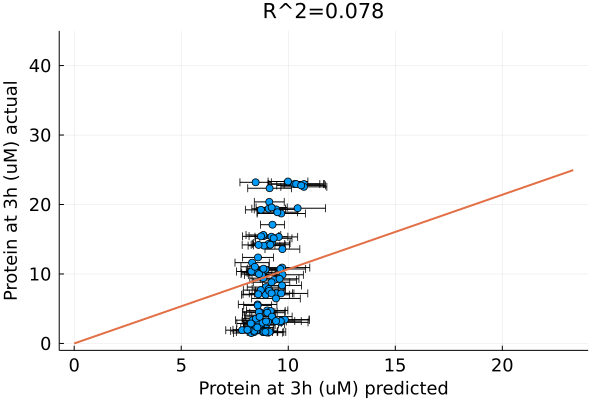

In [22]:
# Load ensemble
iter=1
ensemble_MLP = []
for idx in 1:ensemble_size
    ms = open(io -> Serialization.deserialize(io), OUTPUT*ROUND*"/model_"*string(idx)*".jls")
    push!(ensemble_MLP,ms)
end
# Predict using ensemble 
pl = plotpreds(ensemble_MLP,x_data,y_data,0)
savefig(OUTPUT*ROUND*".pdf")
pl # show plot

#### 4. Propose new compositions

In [23]:
# First generate random array (which does not repeat previously-tested compositions)
grid_size = 20000 # originally 10000
ALarray = generate_random_grid(x_data,grid_size,NCOMPS,ALLOWEDCONCS); # takes long time for large grids

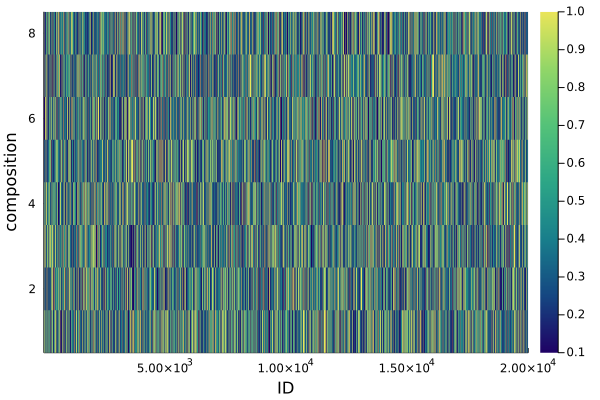

In [24]:
# Have a look at the new random array
pl = heatmap(ALarray, c=:bluegreenyellow,yaxis="composition",axis="ID")
savefig(OUTPUT*"randomarray.pdf")
pl # show plot

In [25]:
# Use our MLP to predict output for every composition in new array
means,stdevs = ensemblepreds(ensemble_MLP,ALarray);

[0.009090226265210345 0.008875082436818033 0.007691613777339984 0.008173836811577984 0.008266142865195558 0.008574108603966034 0.00757276573683776 0.008057804880896616 0.007617621784839183 0.00878300814971335 0.0091228220268478 0.0073461706578536665 0.00932913357194732 0.008909514665829957 0.008860252009769325 0.007195758946818446 0.00847919242621574 0.0075656030438439725 0.00857004133813908 0.009101485185202138 0.009904121585202257 0.008802491481727546 0.007269601474345234 0.008180018273709337 0.007996687652587747; 0.00997258740362128 0.00804970588304954 0.010026437771317715 0.007925171879172022 0.010303862036933176 0.009993622330783908 0.006918575988957733 0.009326519512477977 0.009226502733287616 0.008904231038731806 0.009025176987051964 0.010725404977452191 0.010044594445531269 0.011362472653713625 0.009866347104568192 0.00907980140963743 0.00911235509195937 0.009227693380296165 0.010876436504591788 0.010127953745128461 0.010673691852345317 0.01018566277802066 0.00983144653051447 0

 0.008320050837504703 0.008976986023273698 0.009483458054575594 0.010562913520506492 0.009245420054652289 0.00760493132147288 0.00905073040807669 0.008588130210917528; 0.010406586028701406 0.009449658667425222 0.008386393696886596 0.007662059231505968 0.010044735416032298 0.008782440528776284 0.011319459417918242 0.008680151410266295 0.009626934130775242 0.009786617303453541 0.009025176987051964 0.007434347909981232 0.009665895757258545 0.009199974097765351 0.009863357402903603 0.008019370249379074 0.008124825458400195 0.008863990388818691 0.0083593517771616 0.010732116090302023 0.009311385186426544 0.010544273182900892 0.0074510542181173926 0.008651776571748957 0.01003873645502035; 0.008221632672881363 0.007901236453272417 0.007455754758929551 0.00794986954619857 0.008073510602116585 0.008247753850015123 0.007271814101250347 0.007528562624832339 0.007387694428760919 0.00738176650754329 0.009025176987051964 0.007270720376906843 0.009170074491150579 0.008876161491506183 0.00845910670290

 0.008274347818257945 0.009046411206338773 0.009025176987051964 0.008149965691938517 0.009396141288894832 0.008605713867824912 0.009448743244389532 0.008751506371590377 0.007046543035475901 0.009373588115470061 0.009080190770340855 0.009515537897771412 0.008905860461037127 0.008517818638649744 0.008792298287671137 0.008515805844884407 0.0076792021749833225; 0.00789193573794957 0.009367859166219714 0.00942969042866359 0.01033133476234041 0.010569980225877327 0.009466457772127995 0.00705112668969014 0.008259868434707586 0.008746194551103587 0.00806027783906495 0.009025176987051964 0.01017442677017822 0.009699853023357746 0.008898845293328586 0.009605902811469485 0.009829012475762407 0.009323578515691839 0.011259660526794214 0.008529582504689876 0.008846356628244675 0.010309610641729108 0.008656809642382978 0.009619121550780405 0.009188925845042323 0.008748652909089771; 0.008965509016807696 0.009307433833504112 0.009006378711513855 0.007857656390111462 0.010206779741882813 0.0085397246931

 0.007598474680733314; 0.009893464078103768 0.00780346473172686 0.008892474710884847 0.00960757781730596 0.008613128611600037 0.009219186761899837 0.00776015127143092 0.008258547394070448 0.008769185814373803 0.008211108827763351 0.009074862249584344 0.007380213525381934 0.009337657118369255 0.008549046587048283 0.008958928640927562 0.007980834769881333 0.009530512434965473 0.008832902884446417 0.00922121571820536 0.00853046541538417 0.010452449695138871 0.008667603707821164 0.009066088480267648 0.008339358681904826 0.007801247080012237; 0.009945840418569017 0.010313266219029327 0.009973137126731117 0.010455910929513658 0.010968938546031023 0.009402046415729361 0.0097375667609962 0.01032631422236425 0.011951864981772971 0.011765251595968855 0.009108417073722539 0.010315434085367838 0.010347002866817383 0.00904933664909087 0.009348032843351376 0.010394582645788554 0.009456564470814586 0.0088620785116592 0.010532696663139616 0.009664493851600382 0.009589238725531444 0.010112044268639563 

 0.008917785119234332 0.00984962435652681 0.009240085566975004 0.008872162051871737 0.010331179529063799 0.010719150421121598 0.008814886089868204 0.007694265562361595 0.008945184820669803 0.008620024652804426; 0.008295639728193418 0.008530813921909446 0.008828378954800084 0.011039414788056815 0.008234058544850856 0.008498362392741345 0.007666650540769034 0.009062761558200327 0.011526293168053777 0.009664197562797551 0.009025176987051964 0.007831621456755214 0.009675984203587762 0.009993972099736462 0.00877487239979626 0.009838855518328322 0.008362112950711147 0.008543381750181076 0.009715473200980762 0.009783588287513635 0.008930642573748602 0.010253583046587434 0.009797771150734816 0.009888974387929218 0.010791748895883918; 0.008922747561826136 0.00921285380738733 0.009323850798471641 0.009827253511356234 0.00948772467371537 0.009393765037645007 0.007291606859841062 0.008159532749898075 0.010024549002813377 0.007659255475187993 0.009117142578433653 0.008102514729746393 0.009271561500

 0.00854565611976392 0.010297464973795844 0.008707490772461739 0.008658501797667114 0.008812654372771447 0.009025176987051964 0.007748014474791803 0.009546606685532668 0.009293225653222666 0.009490512477520661 0.007836042428896595 0.008042223788596193 0.007931484417085076 0.008808228310095168 0.010070852584357748 0.00864220235350064 0.009553218717350858 0.007312004534333916 0.008192473994442956 0.008534175214177639; 0.007979201022625466 0.00826057109465262 0.008007459597248252 0.01081487749121573 0.008916754002796057 0.008824703862890294 0.006324451091436098 0.00777697133282677 0.008788265759021112 0.007516472071698542 0.009025176987051964 0.007620873730362701 0.009611647329287145 0.008557809456155998 0.00870153763628851 0.008551438891510612 0.009038424191401122 0.009998170693660775 0.008903264544675629 0.00960546515460306 0.009761029669022198 0.008480353256208602 0.008983359982470435 0.00859315605327998 0.007762637392482809; 0.010798261750018773 0.008465502851529066 0.0082328011884926

 0.008889498878717018 0.00955135950040261 0.008791529247477791 0.010672004432884572; 0.008453811400949973 0.008463383419432709 0.008792362843613078 0.009835691039101367 0.008956262294543648 0.008527427259872074 0.005823715230116936 0.008914054200548173 0.009372040289799849 0.007756332760143928 0.009025176987051964 0.008179485813407059 0.009365074948401358 0.009647795591860825 0.009095557854183036 0.008951916699530913 0.00888030504008057 0.008187367197764302 0.009779273522462006 0.00833184408017284 0.009057826002258889 0.008932848863217706 0.009234174491866995 0.009189838048276066 0.008731841686888819; 0.009506421813244435 0.009269923352380225 0.00846203027093053 0.0073807881331803896 0.009169338677919487 0.008925041672464506 0.011115699645757664 0.009041046211573993 0.010758897601848963 0.010859437928262966 0.00923877387152596 0.007481726427135046 0.009599557247441822 0.009722011970536053 0.009711416363343751 0.008845819674194308 0.00838422502477791 0.00802879792355444 0.00827248326649

 0.007494483621386287 0.009249536198972112 0.008602910515395006 0.00930514381090655 0.007748005315650637 0.008413903838427668 0.0074587205089977834 0.009383144538811516 0.00902129457413742 0.010643261171518653 0.008667603707821164 0.009265600199872534 0.008221415831834835 0.007863544201938926; 0.008652824516015284 0.009019615163618154 0.009154377944088667 0.007752268586579158 0.007354784262002085 0.009026345060716916 0.00818559557058854 0.007765768013681004 0.009696180231766638 0.010715002147943364 0.009025176987051964 0.00729578310162893 0.009298787525068679 0.008989574705254971 0.00952715286572021 0.007376897851148313 0.008848349173565796 0.00817241260442961 0.007885920858744257 0.009511891207483613 0.009709093292968542 0.008641214844982592 0.007146518105687292 0.00901206227999738 0.008429659075463152; 0.008796399222268643 0.009213408447818719 0.008961915047136455 0.009584542860531918 0.011511190909945967 0.008942177148644146 0.006447350470183938 0.0084451231103377 0.0084722336526580

 0.007993123594696441 0.008095845382206536 0.008887278123114534 0.008371163482098102 0.007748980921681648 0.008196422409550364 0.00815707730222806 0.008731435210675034 0.009025176987051964 0.007848738881648682 0.009431508177583056 0.009018552942781331 0.008696457962694299 0.007858070596609024 0.008476513460878698 0.0072920126474953694 0.008991279827855088 0.00887751266673348 0.008343262198516076 0.008954260104337376 0.007396242530642654 0.007976767392388895 0.008707425249390364; 0.009057159982966616 0.007845156172004595 0.007818729729256877 0.007844105298605285 0.008073510602116585 0.00806010723678378 0.007897898059348585 0.0077575000174515294 0.00797640893764105 0.007566885958461342 0.009068068568773778 0.007314734458955577 0.009269876081600958 0.00891261374239467 0.008502873319980928 0.007044899352741267 0.00786572743603109 0.006814560099739679 0.00881334827636988 0.008444176307376027 0.009462162233669653 0.008688611303525239 0.007263121087306831 0.007789348165981665 0.00768266881502

 0.009097392995077476 0.009670674873642211 0.010615809307910761 0.009186048889982841 0.007667486571124619 0.008435416099235179 0.008919399644355975; 0.009441363411956253 0.00786333519859636 0.008604205118741663 0.009076813124534108 0.008866971780741627 0.008406043968809784 0.0081145289138662 0.008129801719556934 0.007331563786541132 0.00944559892542085 0.009025176987051964 0.007532224874600509 0.009375642536870244 0.00926928934265692 0.008868031630326664 0.007037634713776604 0.008930559681982305 0.008585926313638088 0.008844913153520147 0.009138188665343562 0.010429568922478462 0.008869208466567321 0.008565545457565667 0.00816247126628117 0.0075698313727024374; 0.008187870455612015 0.009303702486958847 0.008901484131956332 0.011438987656732446 0.008073510602116585 0.009068608312320902 0.008035447724617608 0.008643630100235491 0.010613522332899283 0.01014435438452933 0.009103204504703331 0.007309654486889431 0.009697968299376185 0.009902685049743752 0.0089227498121355 0.0092910529788620

 0.00864778276755769 0.009736501376040579 0.009390582133060321 0.009184534997571657 0.010016770469131324 0.008938886939189997 0.009972896527045456 0.008610502063979342 0.009085625641124098 0.01026363635754985 0.008650886589683037 0.01151986144095493 0.01059936809407315 0.009736587156883086 0.00912597927420952 0.009074569407093258 0.009471159548657605; 0.00831409940512439 0.009389726725995166 0.008491662577431822 0.00968433995205073 0.010229637093982138 0.008949090942321694 0.007602512053795654 0.008593362394811864 0.009518967617450243 0.008399524433005219 0.009025176987051964 0.007907185067111973 0.009351300595017351 0.009051360644574718 0.00879958755772965 0.008607615168239394 0.006963047283153205 0.00827216145397439 0.00892818778847779 0.009137352879100525 0.009038413340892894 0.008667603707821164 0.008894644389124204 0.008430450379830751 0.008434662001504384; 0.008570785568817737 0.007532824171202853 0.008150188629623283 0.009969434502806745 0.008073510602116585 0.008472679548944317

 0.009006380463336204; 0.009646004397966859 0.007999813294818827 0.00983106531515614 0.009606981327802116 0.010813528887608524 0.00952339195021075 0.008124534998196153 0.008501213154307309 0.009270974431989733 0.0077352511256997755 0.009304257943863184 0.00878212015118929 0.009330401532990232 0.008737133990917492 0.009683087229591776 0.008574520371692273 0.00962868635123908 0.008690442589679381 0.009678752023239775 0.008693018216944447 0.010840414081317699 0.008667603707821164 0.00915852453969598 0.008419452089642045 0.008055245413227465; 0.009025645745584353 0.008785427966327575 0.009332125894054315 0.009295040389590479 0.008701550752959546 0.009624509793159694 0.006647609286460169 0.008838802673321424 0.00998076469427148 0.009332063346310135 0.009070850781714969 0.00982850528317452 0.010442451428219937 0.010253738912193652 0.009434214120808665 0.009312513916744734 0.008894594767454463 0.00961438600441989 0.010414477593187876 0.008492775352184748 0.010594121915832798 0.009560179485976

 0.009194567853610827 0.006843903475996371 0.009046968724639922 0.0087043331457379 0.008591703632523649 0.00921770935231134 0.008783584136418995 0.009197012759316156 0.009073234505759548 0.008640025504808031; 0.009085271201321552 0.009337773058070795 0.008719427253825029 0.00988588100486933 0.009454135321312097 0.009257650940188327 0.007656458985808601 0.007618354492001882 0.008996179639434877 0.009400968181980406 0.0093710723782136 0.00823570733131872 0.00912005123674431 0.00861353218296512 0.009477349513921995 0.009008869489747473 0.008125344766720576 0.008744806771845677 0.008938183059602828 0.009146965749616577 0.010689860347147228 0.008662916344388288 0.008965691328690807 0.0084349819315485 0.007863603290459098; 0.009116052598214675 0.00854134799389219 0.009420304950700304 0.009841746025477513 0.011353943184095147 0.009300215503008332 0.007490561553256857 0.009123585669195513 0.007944784943537533 0.007972425719679724 0.00905341031521059 0.009767199831312657 0.009661458175886246 0.

 0.008098660845155637 0.009879324572683866 0.009813156953657115 0.009118115135378118 0.008557589792861309 0.009532110638707934 0.00930211654091771 0.010181049096187045 0.009277017482278674 0.007555245755265734 0.008672667816549759 0.010522029477999507 0.009763163461943464 0.009844296807459523 0.008658895748498445 0.009721778878872224 0.008786573749991406 0.009275486876454925; 0.009443186573020484 0.009077264277833579 0.008978304169614492 0.008890954758210553 0.00907854287171449 0.00902546127305499 0.008555089291380342 0.00833936765599672 0.009580189722937619 0.009008595212297351 0.009377419485308798 0.007518384210959892 0.009283922955939177 0.009043798443133211 0.008918620937722334 0.008469502682725165 0.009294973726508901 0.007758797049410959 0.008976691379467126 0.009055995194033141 0.010412267609063315 0.008668340875126647 0.00763197948494258 0.008295652039474815 0.00829216969894209; 0.00897311953179937 0.007938642302070243 0.009275994025133207 0.0082784395059286 0.00984472076599319

 0.00814674487960776 0.00753576216750174; 0.009489496114617461 0.00945271845025181 0.008914301404016042 0.01142167683610214 0.009835221621796205 0.00871272908775892 0.008210858323612569 0.008971712516484954 0.009588882786009764 0.009473718444094274 0.009025176987051964 0.00808603059902651 0.009837480027969237 0.009313015648517626 0.00920286607860731 0.009059451210830675 0.008665408781024193 0.009178213041916555 0.009302294029294165 0.011244953740208573 0.009880893174476034 0.009305688460808646 0.009737674837897866 0.009058956766240116 0.010926147499607393; 0.009077038670555398 0.007690133308817939 0.008586000864017375 0.008960004421534088 0.008734737743688284 0.009353340484427052 0.007925603322176959 0.008463744857747786 0.009937822518110172 0.009136110491667957 0.009523897392550822 0.007778664714450654 0.009305111245152818 0.00868998758584519 0.009105222995104592 0.008308043380520677 0.008968566222469375 0.00834769894263429 0.008768227697382648 0.008875044193210047 0.01082117577176916

 0.00994329455773855 0.010303388066573778 0.01010937404153043 0.010247136725625125 0.010666881879347103 0.009058902579855217 0.010622486776731376 0.008667603707821164 0.010591486596030132 0.009634275824393588 0.008443640814471975; 0.01009490931322822 0.008142827013259718 0.008006487934628922 0.009827015487542952 0.008073510602116585 0.008888565300895736 0.009158542725963177 0.008961663820716764 0.010417421629140066 0.008348751417589173 0.009025176987051964 0.007462529384559561 0.009433930691164839 0.008978369973096841 0.008790299938276219 0.008442073788800452 0.008311501660411636 0.008150343770258606 0.009225106862508292 0.009407709811256312 0.010773775665483279 0.009119378768543102 0.009480330415791372 0.008638063298029288 0.009404815183151899; 0.009731717368819923 0.008400777146679141 0.007881084085465881 0.00990522236295036 0.008119021617183971 0.008759845485442678 0.008866048547389493 0.008641577712694491 0.010150002335114542 0.009537753128725167 0.00928109314048906 0.0084535421281

 0.008721247346116262 0.006986869838098354 0.008406236652975647 0.007223354918468901 0.008317206346482895 0.009025176987051964 0.008076536801764352 0.00942043279628248 0.008837691723371309 0.009123341932950505 0.007617445983127427 0.009324874512585037 0.008432970690389494 0.009298151722864169 0.008963724339534244 0.010499460278900759 0.008742671950138404 0.009434489985717179 0.008668987325419422 0.007818846020075012; 0.009287243014310073 0.01034429132058403 0.008749645231140716 0.011239154802605934 0.008620943094488744 0.00940745972077215 0.008926928233571503 0.007565464971517061 0.008938564867160244 0.011344650689772222 0.00974858682945046 0.008127975649650744 0.009373917295582686 0.008900546850895003 0.009308258239742496 0.009668341157709936 0.009586665149602772 0.009477970134954576 0.009247402878114085 0.009803187734934889 0.010502136285123928 0.00862623156511652 0.008031418655347265 0.00854098618653754 0.00945478726514849; 0.00907367271052218 0.009689224566288627 0.0091877182827485

 0.010700368628597669 0.008262465142654989 0.008949353566815785; 0.009100521348261673 0.009519853699496525 0.009084715397703544 0.008722290478424953 0.008760965844231049 0.01009396925170397 0.00888132055191641 0.007855447042362977 0.010008334632326431 0.010698819893694547 0.009497029972844715 0.008875116839884711 0.009825298575744207 0.010863378166804105 0.009785492897630355 0.009722605809266257 0.009076269256937615 0.008777187100621626 0.009999456395299242 0.009298787130043113 0.010754514786531034 0.009721584474870251 0.008685015722698943 0.009115042011343681 0.008993150761903896; 0.009130693527100655 0.007944782432234426 0.008202992625600081 0.008713906261467482 0.008730684410586463 0.008581996118129334 0.0066188075486761175 0.007807984304585634 0.008011246350711553 0.007552537219184231 0.009025176987051964 0.008035070507481977 0.009277688085333963 0.009393792872533724 0.008805546740871074 0.007255323022798491 0.007642858014317286 0.007464748151367122 0.009121118486787776 0.008558758

 0.009553009718886266 0.008903665903844258 0.009341269931387428 0.008254818513754949 0.009150995248794275 0.009118457497682824 0.008846665691911174 0.008581943337274613 0.008705608950355586 0.0101729195681752 0.008930534542053203 0.009134189857951733; 0.010438379355621212 0.008146987097422386 0.00867127041257201 0.008426351290121228 0.012140437541706042 0.00894281691538888 0.00774838500422145 0.008910799287344333 0.008003848014467858 0.009621296124935466 0.009045790324984962 0.009663802586580722 0.009673280042782912 0.0088936823799614 0.009570385012553395 0.007705292623362437 0.010050657515827437 0.008726371454136286 0.009243503074987076 0.01077266378390791 0.010805144870273103 0.00945333640010292 0.008765858340698787 0.00862461343978372 0.008178206780459513; 0.009158229871676131 0.008527694479299635 0.008156600133123356 0.008387094807246302 0.009253559526265493 0.008702364170441337 0.0076708556280789 0.007709079446448389 0.008078968530725518 0.008042974433049195 0.009202453409590023 0

 0.008648909497901588 0.008939649086480452 0.007852371101065039 0.008768120567291746 0.010040840925647339 0.007492714674927608 0.009202684964660278 0.0072992617759011285 0.009643209913860706 0.008461337896181314 0.008773559680122445 0.008122622000063546 0.006886939790015166 0.007476743288381781 0.008362872715430512 0.008731770446803436 0.009220253770441495 0.008667603707821164 0.009355529469881748 0.008188741769549555 0.009079076759095757; 0.008894068975316282 0.008560922081614943 0.008550214044921452 0.006988045971176997 0.010094069928722665 0.008834833916433077 0.007892093722411554 0.008767936672676238 0.007767168168754943 0.009396452807981674 0.00904239110859231 0.008387434391402195 0.009427065531174856 0.00883073685472312 0.00966764090917168 0.007432924929303135 0.008818719454415641 0.008015296434607909 0.008616504909907213 0.009506656408292923 0.009660239476536507 0.008719933998434149 0.007657415701605709 0.008778043366421264 0.007580672765630087; 0.008465456955215514 0.0085528293

 0.010656247198393812 0.00863243692493587 0.009076747255795072 0.007898431082150421 0.007490975574846377; 0.009450245595168843 0.00861604163483801 0.008871218319940598 0.008466944983617887 0.009643458889803731 0.008811552356836413 0.008905339549304853 0.00823780924467885 0.0082517076361853 0.007557835801030999 0.009025176987051964 0.007634862903434054 0.009387110854060566 0.008801035389908497 0.009120740549363297 0.007325597640329197 0.009362743693600415 0.008369807121806927 0.009028285198180823 0.00875787948109491 0.010345419760030224 0.008638286190516892 0.008221678059813591 0.008366226603304388 0.007260563095516291; 0.008294491592598093 0.00860575912419765 0.008286221518600452 0.009226307333807582 0.009051320105792866 0.008598363849913837 0.006629127665937897 0.0095770323348855 0.00935931436542572 0.008645795911055208 0.009025176987051964 0.008700770700030055 0.00977209679313051 0.008909514665829957 0.009033657480592976 0.008513682670324138 0.008633423939040387 0.008261952831459328 

 0.008649245568549322 0.009601519318663574 0.010474184453846267 0.009658997603395354 0.008787456421705768 0.008790365096642829 0.007962298820667695 0.010535188308480561 0.009296538251601434 0.009870279716112106 0.009030885747385501 0.008527096397786678 0.008257542105842732 0.009031640419816104; 0.009336260673074824 0.007923616278051653 0.008410730264896107 0.008316365801508855 0.008654887487118287 0.008267112711021065 0.0069281034165128794 0.00794655017429492 0.008380025067535515 0.007358344008603563 0.009025176987051964 0.007702915523939554 0.009277822624225001 0.008895922277473281 0.008712801368652491 0.007045682118961626 0.008293611664431651 0.0071337810335816215 0.0087424365070239 0.0082864829895166 0.009394050500469299 0.008667603707821164 0.007733497155939376 0.007914257586534211 0.007393368870378009; 0.009316268344558051 0.008147286469457097 0.00867834419287757 0.011305111963384355 0.008073510602116585 0.008551655117647612 0.007766003238744747 0.008968444319058721 0.010752709944

 0.008067749057715335 0.00700987556197822 0.010500768139950038 0.008827228138336382 0.009097319803679388 0.00893415004398859 0.008521260994306838 0.009384701991702764 0.009166162159799408 0.00784672000554701 0.009495588482408893 0.00881586080658491 0.009359359736679583 0.007967976494297832 0.00867449457145041 0.007954131795159098 0.00862528589106504 0.010269946924175186 0.008973540821479692 0.009745887775803342 0.007405570977835612 0.008466716022895743 0.009177999567063933; 0.009272344254778827 0.009753137906980628 0.008343150928567002 0.01046507501311703 0.008994119724093355 0.009127470187204514 0.008367395310641412 0.009504813158515915 0.011341761205477243 0.009234028694425312 0.009025176987051964 0.007451591679543112 0.009417009910347867 0.009669984517720701 0.008886410125703315 0.009421295574697583 0.0077812616915497665 0.00835102443480817 0.009011324691722378 0.009380582913055713 0.009916287239763953 0.008952635276919495 0.00956055663041954 0.008738168959387579 0.00980861475215362

; 0.00933044690508739 0.008590430049891223 0.008196135124222967 0.008355456203778503 0.008214225804794247 0.008582931311773085 0.007418902107672868 0.007474612392534207 0.008508002635048858 0.007312767110169711 0.00931259270853942 0.007680947409139961 0.009301249969625155 0.008872707655587512 0.008987684141014338 0.007431233756774447 0.008603055337664565 0.007397286801231538 0.009341750412403808 0.00850157842427408 0.009808946310700164 0.008667603707821164 0.007815697950978081 0.00798281423928158 0.00744940560301424; 0.00906655010395617 0.00916887655752856 0.008254784887095601 0.006669727393035042 0.010452581959721888 0.008873953843763797 0.007737458973968629 0.008707304298618525 0.007990065222649598 0.00953787939916088 0.009180983246084445 0.008485592885376344 0.009555989437950515 0.008867872011430614 0.009628264679829659 0.007659975961028783 0.00832886521709722 0.008713009963147436 0.008821364386758537 0.01020110111720774 0.008284497540261749 0.008701103598892585 0.007346744524763393

 0.010207898118050143 0.008846588064079846 0.010753136690886182 0.009171637937205199 0.010704199753153782 0.00868324777769242 0.009675328189435468 0.00893319062165381 0.009628172717222612; 0.007698413596999542 0.00778834509599825 0.009222786286632378 0.01027544897993156 0.00921552937721186 0.0087881266779938 0.0064072947154589326 0.00788079449787409 0.008719837847808602 0.008338922442403876 0.009025176987051964 0.008345223697498294 0.009492255075935707 0.009608239425636761 0.009141160692607554 0.00917081037103942 0.006886595488770237 0.008764702741434826 0.008977850754280682 0.00888789651611344 0.00944950431061063 0.008660902484681968 0.008338444502221693 0.00888812843025732 0.010292710067474236; 0.00934036912156282 0.00889646278906898 0.008796203934371095 0.008338634969647823 0.01162932453811703 0.008797479033242293 0.009619557840732772 0.009057679984027968 0.008722063458555942 0.00961453399033726 0.009297241943682826 0.008462285844964482 0.009662754745295574 0.009133784457099734 0.00

 0.008596594396110956 0.009476402281324505 0.00806574606429144 0.009025176987051964 0.00732426389525371 0.009153760338199141 0.00907687484284202 0.00864100964488649 0.008163480873493714 0.007517864748466242 0.007765855826830849 0.008712820336673527 0.008544172263562041 0.010088911889719157 0.008673092258725985 0.008494301059738255 0.008611282739554596 0.008316458166728418; 0.009472069800652806 0.009974849131771048 0.009593293708206815 0.009336625437565388 0.011901139998156148 0.009030779450745957 0.008770858134024654 0.009014763712741137 0.00978038771460714 0.009701832177314743 0.009025176987051964 0.009528049967618218 0.010084955648259957 0.009215219080115453 0.009737520533084828 0.009619749246398676 0.008556464353560247 0.008434211640065206 0.009866426343463727 0.00887261397026557 0.009666369100177886 0.00918127624252828 0.007976117485077643 0.00934214017712796 0.008601627008479341; 0.0095622034054355 0.008305760135112472 0.008376352856400813 0.010792669814302401 0.008505166751633703

 0.008843503298601384 0.007777119379188107; 0.008297933945263942 0.009947923614216807 0.009179656019700997 0.009886219890745668 0.00923880622862543 0.009184318010676549 0.006885880069815527 0.008319935731184112 0.008244816847981529 0.011002667911336955 0.009086428445784568 0.008894783565992187 0.009520315312232772 0.008909514665829957 0.009367374577189919 0.00925430204630977 0.008492060907159366 0.009386815775158434 0.008806884104554899 0.010464415680160951 0.010676139528056384 0.009455198187300694 0.007530384122553624 0.009400416176093822 0.008479041224462839; 0.009827305974000049 0.008042929876494244 0.008106691458420077 0.010421757666874844 0.008407187806138122 0.008677366992182422 0.008518791208727155 0.008978171095053883 0.0089227665900954 0.009970498322327881 0.009025176987051964 0.007779582991096064 0.00961556146769103 0.009283530845088532 0.009137443936931385 0.008035348733910291 0.008231032580067965 0.009056552865730212 0.009104380917866589 0.010457928725420593 0.0095286297974

 0.0093335958862793 0.008803359614927446 0.007975433172999105 0.008615623379214862 0.007479845344150745 0.00912956155027765 0.008991736874076634 0.009193048989634385 0.0084299963271428 0.007322860433669608 0.008064781629441124 0.008863190761451945; 0.010644676851050902 0.009548734052861059 0.009159831357734962 0.010510298419669183 0.011640888989158077 0.008728415534936777 0.011787375839077524 0.009414253321699415 0.010223476267330136 0.009100788336478578 0.009025176987051964 0.008274476486807344 0.00992359717356128 0.009704956172246149 0.010046333811743913 0.009018590655660696 0.007871839085886899 0.009153914887931387 0.009209711192689138 0.011521567240258991 0.00862330371580389 0.010256359171157536 0.00959857264015392 0.008740786092636576 0.010638591651201311; 0.009824095123663654 0.008144805850065901 0.008236949807540934 0.009788412054534859 0.008264713985964196 0.008294084200803775 0.01002911700587143 0.008425168437019525 0.010044030230900905 0.008744260468213976 0.00916332499267158

 0.011537235852581656 0.009665429239861058 0.0135829019173724 0.011996006544866445 0.012431205186652748 0.010577433196242814 0.009377567050463153 0.009998162926591999 0.010004952110471846 0.009350708957803888 0.009575458301868003 0.01076500163822511 0.01009372174213784 0.009521221759731845 0.011978930375079095 0.010624654482397173 0.01072753527192392 0.00975369881564642 0.012047406863031053 0.009955502379419764 0.010385441579800814; 0.010164661694561644 0.008149926782625178 0.008800685626161845 0.008640915434901683 0.00805621201619302 0.008876528448612362 0.010752440473339642 0.008723101863390006 0.011127331001977898 0.008140987415736236 0.009444809629317279 0.0072992617759011285 0.009337761641747466 0.009047570576323471 0.008598802009573057 0.008437661164560116 0.008515901459035316 0.008396573248509547 0.009410910983935023 0.00921881472140731 0.010593644449035534 0.008698484376562478 0.008336751974634947 0.00860335338944785 0.008853575057774912; 0.009232355909830525 0.0088523689720687

 0.008185264949137018 0.008667603707821164 0.008957631067268134 0.008424837189376881 0.009014689175602258; 0.007915529398537005 0.010285339908823245 0.008372756626191514 0.010535940781159155 0.009724415418275392 0.008832241432302972 0.0060479921574696765 0.008131654988164231 0.008914907472920066 0.009576853718973398 0.009076451961881705 0.008078495717748161 0.009570572519675528 0.008781943053506035 0.008687376275316723 0.009165975772426886 0.007325857383487959 0.008972624749707175 0.008876505551425601 0.009812484312980315 0.00953002080607556 0.008557030200093574 0.008877698277502413 0.008532426729884555 0.00927081106546663; 0.010078572055176534 0.010177873807803797 0.009095171940484294 0.0080409532874483 0.01150372873459505 0.008994485450935136 0.007927335342528433 0.008775929127152018 0.008296045634949345 0.010815659262474193 0.00956457208144228 0.008581666500931943 0.009757689677073435 0.01071883683483324 0.009638319347672387 0.008396270273568028 0.009178696380748117 0.00989954404386

 0.009613716780038646 0.00936828442838765 0.009737418300869655 0.008354118361913921 0.009719690202863139 0.009603474529798827 0.008589112597456757 0.011046434256126038 0.009439466267473516 0.009160435596294403 0.00732726415386983 0.009435839651256875 0.00966192375995902; 0.009146291610397036 0.009013042368170422 0.008321337675721338 0.009675921882593445 0.008526692512051287 0.008804680213721291 0.007248988184981657 0.009272834609706041 0.009971478106833008 0.009912001533435907 0.00908497140001549 0.008548577931923571 0.009792523673022031 0.008909514665829957 0.00884178492947666 0.008805507552312191 0.008533046782177799 0.007943287986588122 0.00939582073705469 0.009457322463173745 0.010652203698086731 0.009774270121445616 0.009229485046531653 0.009265201731113584 0.009293303559239114; 0.010192669108579924 0.010306088940112002 0.008737993374036983 0.0117510592417215 0.007842266421066236 0.009277963370593095 0.008482501246602823 0.010845843472828316 0.013689191138294346 0.0114291819164505

 0.00851533249265641 0.0077083039198833775 0.009126820004633926 0.012344900664475173 0.008641929884045944 0.01137972274079366 0.009203504889589344 0.009491304223426773 0.0072992617759011285 0.009203142863001633 0.007706041106194709 0.008856499546628399 0.009526554981630235 0.008896644875290797 0.007804959314862996 0.010152394304103782 0.009702857343031961 0.010273278309855704 0.010114987718018224 0.008482240003797794 0.009068415037294532 0.009801601621580893; 0.009450524324350146 0.00864100232749562 0.008493030140291652 0.010522178435223857 0.00820845144445311 0.008701606760213618 0.009576253055487151 0.008886250412870573 0.009832102817982993 0.008149682204979998 0.009025176987051964 0.007338469044468247 0.00959604816416012 0.009666694630473937 0.00901851815938456 0.008169683471302612 0.008445507173186175 0.008928667117637007 0.009536314059686114 0.009564998194269106 0.009973294808900173 0.008878703139771205 0.009517260858500565 0.008750042014564747 0.00925468786600535; 0.0089016829159

 0.010465333271560948 0.009036791921493061 0.00858081421484561 0.008996346756399414 0.009222702160227752 0.007495854446153111; 0.009178469087034062 0.009693002765985724 0.009209156343881735 0.008668247866147897 0.01126959276128601 0.008501714241197698 0.009391999241064831 0.00862485014251081 0.00900391987495126 0.009281380484381622 0.009025176987051964 0.008740545085983932 0.009721985537103973 0.011623995813128837 0.009086177101232003 0.008592783861893195 0.008513103264409332 0.007694064657335584 0.010939364331341716 0.009816199936020837 0.00858549763204379 0.010218952566054356 0.007396823573425113 0.008287873342054922 0.009607942926459806; 0.00948136644558262 0.009161382493584506 0.009098708032973388 0.009673283435340102 0.010093285040228321 0.009178909274315746 0.010039022837732734 0.009584648417925926 0.009719141692006765 0.008800659421339818 0.009025176987051964 0.008082098427674054 0.009543258900225523 0.009340569372935082 0.009119078533517127 0.008961618999577963 0.00703850310430

 0.009025176987051964 0.007898253093695544 0.009771988770296358 0.009438119642583408 0.009277014478150176 0.008834628682054698 0.007746794573037286 0.009122914567039387 0.009402855069320181 0.01099117509327667 0.009531458085205625 0.00965367723029618 0.009610489121710931 0.008752503844518596 0.010751387323759926; 0.009111685584013048 0.008609685111995256 0.008468764809708356 0.00773817601140581 0.008073510602116585 0.008506067920639576 0.008258073681692901 0.007092686831516732 0.007408224113090148 0.009192792938328715 0.009370826138852238 0.007429260777902188 0.009234820777772724 0.00867136435451488 0.0089470233852298 0.007829226105964171 0.007420522712867315 0.008241911924556027 0.008824748467648993 0.00936560715331105 0.009004793182272297 0.008574349941999595 0.008288832728227946 0.008077083201287602 0.0076974693555622; 0.008305130696430529 0.009358801403159209 0.00849020277742796 0.011471180228158 0.008168456263919727 0.008785345833483716 0.008994097659465973 0.00814274941637434 0.0

 0.007892680668177814 0.008232124306115586 0.008073510602116585 0.008594079508982526 0.008588785761659175 0.007978164396478969 0.008561828747117164 0.008165327167721663 0.009294044003562983 0.007630038215021357 0.009287508724024895 0.008895294116511257 0.008711135276483263 0.007842352033118588 0.008373346651911279 0.007841441357457185 0.008902183972074658 0.008719920055496194 0.010566949740417168 0.008710264864979713 0.007700729914973397 0.00809851476806387 0.008606523574288902; 0.009353961823823875 0.008948755456347188 0.007845923371398165 0.008645500752960578 0.008073510602116585 0.009118714133279571 0.008201020151786208 0.00892710242490704 0.010973939346988367 0.011101933947561591 0.009325563696565968 0.009279876155996455 0.009421919889416331 0.008974936060862703 0.008628187735259802 0.00844256883867651 0.008543997271519773 0.008933326515264135 0.008748043646986345 0.010415002903235153 0.010484044898139108 0.010083621266264952 0.00854775526589828 0.008623050562975765 0.0096147211204

 0.009162064591213593 0.010991085527901248 0.010470228544765653 0.01007320152632607 0.00822648223594187 0.009333033375004619 0.009880004821352506; 0.008937569982864798 0.00886246295107946 0.008357040587468799 0.007481885715380191 0.010145054929067579 0.008842363496558401 0.008459777967336917 0.008660827927489421 0.007985558830634565 0.009226808520906505 0.009177700961090258 0.007855196803321692 0.009525434668918628 0.008822108776973593 0.009432669700090058 0.007973845887215978 0.007415767078263108 0.007873285507151214 0.00878994814344806 0.009949062113881142 0.008284497540261749 0.00870908914360774 0.007313706309065459 0.008358954411666392 0.008367760106143136; 0.008860124539865996 0.009651041242993453 0.009384802990026989 0.00956500982455524 0.011076377945508049 0.009516497560657916 0.008585040211975016 0.00836220509481196 0.00885530320290433 0.010552469641996689 0.009179956207069372 0.009506603470282869 0.009580524418742173 0.009396781480616848 0.010107575592988383 0.0090065567744473

 0.009985473010642083 0.009334620653115307 0.007857008570386462 0.008898245231450913 0.008600717762615926 0.009137642815929822 0.008533513367993729 0.00859902778961542 0.008135317353877616 0.008735990060781226 0.008955656691931078 0.010613535833346795 0.008911602617420649 0.008922706951547461 0.008747840314125 0.007643545207816958; 0.010155073603211336 0.01075151730001131 0.010024759621114926 0.010571178090469478 0.008941801771199924 0.009115628227341684 0.0111795947928989 0.00843129154702476 0.010467075230721205 0.01456070846410697 0.009856475341611362 0.007338130145290535 0.0094417420399545 0.00963261771031782 0.009674479991176873 0.009157115795953805 0.009004342584833265 0.009134228224161513 0.009667742627992236 0.010795470481173866 0.008497935794670931 0.008242920035045339 0.007328530176845986 0.009034178543156903 0.010818359380697657; 0.009320641602186366 0.009903763523930475 0.009914209143737154 0.0086385704047302 0.011854492912639146 0.009429277561709663 0.010778329807211062 0.0

 0.008607005740803904 0.00888896822775066 0.0073991682565468985 0.00962500793708171 0.008852406875691225 0.00798096036339116 0.008296299100869004 0.00821178612404349 0.008993090980232212 0.009025176987051964 0.007710594155129453 0.00930495929620883 0.008829627863962703 0.009526957710765937 0.007553786440289021 0.008085235833090992 0.00727933532704695 0.008667228909697754 0.008854149681320728 0.009619694402120824 0.008667603707821164 0.007362715087970808 0.009026825035730173 0.006935466382335444; 0.009352609898514434 0.008593444589350671 0.008642597441462582 0.00880476074887917 0.009641086217946735 0.009061159011589721 0.00807944975110507 0.008882490277491509 0.009115705937797793 0.009825869302494876 0.00928351895196414 0.008700899979157111 0.009647392752736678 0.00923976080880293 0.00931479607888357 0.008457395860431385 0.009006206873366597 0.008235677226432626 0.008327861111140934 0.009939812127775668 0.010638106968366482 0.009876706884865229 0.008295415868040154 0.008778241509388999 

 0.008289415118417121 0.008572899037666162 0.009425663784717452 0.009076769330205401 0.008298480975589346 0.007720353720213773 0.007879091045913767 0.009001980325968412; 0.009382179077510721 0.010215513686545646 0.008502968317763048 0.009143997786111021 0.011036865893740758 0.009176143099533983 0.007927742419375352 0.009595773537043387 0.00936702507724245 0.01033518952814206 0.009129816320972574 0.008558622135598408 0.009874543638845431 0.008909514665829957 0.00956529217910531 0.008872154390567799 0.00939735349261917 0.008500399956793686 0.00868801529205854 0.010587541289616269 0.010179524686525509 0.009865355994849077 0.008399987479395686 0.008986321531837366 0.009690027630624957; 0.009068780878097442 0.009900940779528437 0.009150585011224604 0.010862224047436912 0.008477188113737688 0.009011068643454374 0.009055354775780344 0.008984721466083027 0.009602058351525266 0.01320191346512276 0.009495191191442813 0.009645927114837267 0.009707983355585958 0.008847257271235618 0.00886737226532

 0.007839395257404494 0.010448372103542181 0.009025176987051964 0.00824229334975887 0.009685704868959647 0.008909514665829957 0.009184614114171763 0.008836858758925648 0.007127481490331056 0.008977233002814979 0.008483630958390206 0.009745216129633147 0.008914791343046135 0.009158843833909955 0.007480101740564596 0.008333413381749682 0.00838323120406344; 0.009309789653153717 0.008128394977265049 0.008638434603948728 0.009053079692629067 0.008692798530164778 0.00898624386924126 0.008763140120182256 0.008533636506067031 0.009689921648681396 0.007791361854361919 0.009384236837539884 0.0075420803839333 0.00931952974087364 0.008875156071567684 0.008914224847228371 0.00826206380464804 0.008560452995970193 0.008115574990304339 0.008916939872847793 0.008921057080751402 0.01081863614635031 0.008667603707821164 0.008359310196373194 0.008507825028815983 0.007991535391680356; 0.008676616850400313 0.009974911918704494 0.007972197744294078 0.008509930435064098 0.008375426545227539 0.0090979905906175

 0.009938280159777662; 0.008766934343636755 0.008845055878548025 0.00831959446337199 0.007019413601315035 0.00989552758385789 0.008849060847860815 0.009512242665970908 0.008791723250529617 0.008467270630215575 0.009689044333159728 0.009301318833573265 0.007515414552200064 0.009448153721627182 0.008855066970921857 0.0093878695310723 0.007581381772996882 0.008110536658923462 0.007982031787892061 0.008670409633206285 0.009930755377544835 0.008544109287152173 0.008819050526251268 0.007284532591420806 0.008623922268696122 0.008228144287440503; 0.008730180243136638 0.008848577146606152 0.009427059619370098 0.011680590053778108 0.01012427280951832 0.009081384410890793 0.006714128008027748 0.009501945937297217 0.009127997019590165 0.007990499380672086 0.0092054669700302 0.009542042841295747 0.009613072437655953 0.008909514665829957 0.009273133950188021 0.009072717086195503 0.009321414333832389 0.00936187498413995 0.009894933117403568 0.00850987329144861 0.0105270030185447 0.008667603707821164 

 0.0073778429897954105 0.008436640534502403 0.00829170078786428 0.008761207203611064 0.009026998246200608 0.010496203010383013 0.008667603707821164 0.007594501349818065 0.008143870288892132 0.007882325923988642; 0.008686131941850259 0.008999793757401285 0.008467244451360935 0.008425330417382042 0.008945641325741679 0.00870235692845733 0.007802564537724376 0.007510517086677433 0.0085581186781366 0.008777066437953854 0.009379240678241791 0.007774346656660252 0.009281468706558988 0.008885681837591725 0.009123855218348307 0.00795721508151997 0.00853619799040747 0.008511942497559216 0.008856042788317146 0.009371912057958034 0.009108425910821534 0.008414966843591363 0.0077078997149212436 0.008302766347751487 0.008396144574973658; 0.0092150319632694 0.008515966910949763 0.0077049367831126085 0.008075145091477894 0.008073510602116585 0.008366401807784273 0.007990461441920383 0.00774879413680325 0.007893575170109544 0.007922527219311548 0.009279044657351567 0.007375881896479514 0.00930848593155

 0.008791323176280631 0.008328707826319512 0.00786122399353715 0.008328995877673459 0.010462173712015965 0.009351894924255356 0.008447560509285218 0.0094595905507097 0.009188896625944605 0.009088291475884728 0.008488272496913163 0.008973154185043191 0.008929116092631473 0.009223111810665685 0.01005120759627612 0.010392851468773594 0.009311141030100868 0.007092042015945781 0.008441407086599292 0.009467775907067117; 0.00880355849258099 0.009205698515918865 0.009053938372462184 0.009774227766678932 0.008073510602116585 0.00859285798494133 0.007848709454739472 0.00776186252509413 0.008801452683760366 0.01045297122111574 0.009369410819849279 0.007462090121942765 0.009258152337194365 0.009246641037597121 0.008919692171127815 0.008583363590896741 0.007940554626259925 0.008370247060916262 0.009279112106412905 0.009683017034856373 0.00916061322103364 0.00822668790864999 0.007566254303144226 0.008102667910330737 0.009234222393347622; 0.007841718600518308 0.008537052730189452 0.00815655770297133 

 0.010331273138409463 0.0074877287365970185 0.008378561292543517 0.010112983569660226; 0.009213728241743074 0.008482216528238355 0.00855146103139548 0.010541819183487431 0.008073510602116585 0.008482231630713783 0.008013252908788012 0.009330193980690281 0.011281490433358306 0.007666673715408462 0.009025176987051964 0.007318440956669633 0.009513074300040336 0.00915374555869315 0.008941276565693188 0.009290892576707207 0.007780152884675264 0.008314620129244277 0.009336007580863791 0.009110420358716788 0.009853995427965377 0.009467746291483548 0.009394642109590302 0.0097549287808965 0.009926767497049425; 0.009433369074098166 0.008559044808311152 0.008660275870080827 0.009062527267654519 0.009627314013051941 0.008831544326173894 0.008205429900776256 0.008197197846238976 0.008481717245005752 0.007275610926373747 0.009025176987051964 0.007616262170414873 0.009360673297417849 0.008668845930538956 0.009088748593740904 0.007551900812778917 0.009276793039383122 0.008551706957356586 0.00901021267

 0.009025176987051964 0.008470238868382168 0.00933948125350487 0.00855590509849963 0.009040369786367412 0.008054004658910766 0.009484234920006693 0.009410172629902524 0.008516359666457021 0.008460360789647629 0.009573146942778062 0.008667603707821164 0.009347516969733113 0.008475001983915731 0.008002623648367044; 0.01005084760040095 0.00828317857032931 0.0083422456482088 0.00848142067741405 0.010412200488818992 0.008812713398553246 0.008226191052883405 0.008787891825039543 0.008506778368520953 0.009656293236221355 0.009025176987051964 0.009636462397115794 0.009558702228477817 0.008814500879066354 0.009535908577622567 0.0077431269346751996 0.009845066231398913 0.00858111122624553 0.009243318475846179 0.010174185226647859 0.01085100464672927 0.009297769096820787 0.008054722757005927 0.00863919489868514 0.008056714010203657; 0.009705738520387057 0.0075711042314006915 0.007935099580383943 0.009493508334823899 0.008073510602116585 0.008753698418986527 0.009244420057624894 0.0086870173102389

 0.009658483290861308 0.009252968748755705 0.009435826730842516 0.011771990003274358 0.009527197490669931 0.008755891351926299 0.009079862974534048 0.009415630116206514 0.010948360616051638 0.009496200486811919 0.00912056570337251 0.009605035994065224 0.009022477661997715 0.009843661140888322 0.009010881847494082 0.00990613050084689 0.00923009537286524 0.008858672167186766 0.010599429770964265 0.010677188248626039 0.009068830630359133 0.007552162357085806 0.008921231342470184 0.009127363235481894; 0.009477380038743348 0.008741994949576979 0.009000154639578789 0.008638428280767017 0.009592699751159343 0.008789049295947376 0.007858535447963243 0.008160973172579775 0.00867695838629786 0.009014780542316341 0.009252314577486868 0.008562209591019769 0.009628798895317437 0.011016075780806125 0.009109086752165044 0.008697146810465899 0.008465110637660827 0.008063496361616341 0.010634971074980164 0.009435860205434694 0.008833817567639266 0.009184719045991071 0.007522166945547496 0.0084926715647

 0.007096622790305796 0.008659829953444666 0.008455778877847918 0.008367900521267362 0.008609469170366736 0.007372934412897203 0.007958420043647888 0.007045155194732629; 0.00906757315605405 0.009071952421335891 0.008246401667107946 0.00847530402766863 0.008073510602116585 0.008941504038720996 0.007943449436174914 0.007354357679426396 0.008268733795405938 0.008234608388065903 0.009463975151556087 0.007480112136181366 0.009155194979361023 0.008960364397975344 0.009065708507653413 0.008335424767167058 0.00843869631807357 0.008323173242415948 0.009533641737648669 0.00883140324596842 0.01067734566836708 0.00861637216005045 0.0081310441546961 0.008161792733101901 0.007880645538147825; 0.009452561115110523 0.008452300022275734 0.010020134094205345 0.009370009110533966 0.011871688239576746 0.009227467239394018 0.011777139662508585 0.009138553482935683 0.010598936201157354 0.010012476346714247 0.009433083755231572 0.00861396208319708 0.009538976795862561 0.009663056572766749 0.00969021215644223

 0.008719098195458588 0.010316395258641526 0.009199390340760574 0.009421899023863606 0.009195479165207538 0.008827952357294456 0.008898169581773866 0.00809284745323671 0.00863384243173019 0.008784606262648815 0.009606890534128701 0.010247233528713762 0.010478492061740854 0.009749576906214343 0.006866754716590259 0.008196183818984187 0.009094629962033815; 0.009540310946808754 0.00963027856544076 0.009528497849593325 0.009343873448552063 0.009010420317283593 0.008760055431439468 0.011367842179170648 0.009756447589411372 0.011498985538293666 0.012069545373626998 0.009411772913068397 0.00792684140966276 0.0097318824516133 0.010734902787011471 0.009415400168603223 0.009731269596822963 0.009220903511144195 0.007884815349130311 0.011439832327102243 0.010651745476788967 0.009877357236206894 0.010499277864447674 0.008118295975918356 0.00887891954090385 0.011486930354396675; 0.007837603121008549 0.010430788363224844 0.008230391687808813 0.008614093814412513 0.009272096618004003 0.008968825000825

 0.00744559377687155; 0.009024234477664251 0.008741295793806399 0.009140738481965727 0.009620864721057614 0.00884862275827346 0.009719076740113446 0.007452141826707972 0.007782966493170736 0.01013649230309551 0.009303613452215812 0.009555388248806395 0.008469630728636915 0.00923366263242645 0.009783308889025453 0.00963865864546173 0.010013819526527787 0.009100595625161962 0.009410093003795252 0.010116155900356758 0.009389132980280785 0.010636609455402467 0.008667603707821164 0.009328195476270592 0.008601889266743497 0.009169883006796303; 0.009136278759579784 0.008736412430619785 0.008816088070802112 0.009528754080823518 0.01148467534555211 0.00898091664058216 0.008315375313580446 0.008873612891250085 0.008294144237955138 0.008622848636690486 0.009025176987051964 0.00938476547615761 0.009508213891584022 0.009096250967304804 0.00947480872518933 0.00802622350009011 0.009675003024031006 0.008538037976882806 0.009533307429001537 0.009537722378164148 0.010920191179320608 0.00903174017117766 

 0.009589152516270925 0.007851944571368556 0.009539529254844803 0.008509289900070353 0.009622284859235747 0.009470444590948491 0.01088383442796906 0.008550790319780724 0.009260471579525155 0.008705975905480163 0.007868208143507192; 0.009414333704931162 0.009629177091124829 0.00881763355001688 0.009490468444756216 0.008073510602116585 0.009125787975967586 0.007629045625423008 0.0077849712761383204 0.00973660366619748 0.009126167110546275 0.009162986517212356 0.007768188472023063 0.009277296011270952 0.008990027687366236 0.009702748360273506 0.009595199927471838 0.008054192304007387 0.00949451915629037 0.008640562642719016 0.009260094444207636 0.01050665385762187 0.008539581126512777 0.009358362889695264 0.008477145413966939 0.009196671058112801; 0.008169384153310645 0.008248848267790694 0.008258026771749569 0.009493368895094221 0.008535861541835436 0.009243785776254182 0.0060368498791042915 0.007640383453390732 0.00858941724134068 0.009859714650194067 0.009381962559095838 0.008214342201

 0.009178245300718165 0.007778111363247539 0.009063653995593255 0.008003024727612155 0.0095901668044756 0.00923224976636452 0.0097807915867743 0.009826136194215252 0.010956349429990336 0.009825196335394394 0.008517682230276153 0.009475378744995223 0.008962030598219936 0.009164719584808908 0.010015842676667684 0.010614375511452013 0.009464367181544916 0.007763319357301101 0.009195959788763704 0.00851191900255217; 0.009866540036184859 0.008753425724870067 0.008284970751107961 0.010237796320217128 0.008263301219907083 0.00842304233130436 0.009893664037378215 0.008383957610504037 0.009641460714674387 0.009622193854403965 0.009260319490445403 0.008362602950778862 0.009292991947434113 0.009354022354874309 0.008653213527216215 0.008503373993394061 0.008645145168323345 0.007740786737671921 0.00927911682374928 0.009725399591938525 0.009674040975052733 0.00908502376985029 0.007722999332156852 0.008590314701293332 0.010110184825586548; 0.009202422585703487 0.009689737370074633 0.00894675374905653

Excessive output truncated after 524301 bytes.

 0.007537303016351265 0.009861839231590452 0.007032436393415518; 0.009114198370013368 0.008594821462019751 0.008740396917015083 0.010439176407243107 0.009298168666417798 0.009516140815536284 0.0076729607638405545 0.007585776896113989 0.008753612660908468 0.010851769665874412 0.00957823568045084 0.008534345918834764 0.009352214429316445 0.008909514665829957 0.009426911958087935 0.009690541436808076 0.009531438341005706 0.009869045901621444 0.009382202225366693 0.009684343833239992 0.010673077198701746 0.008512746043596814 0.008271002147266079 0.008563272999582084 0.009003429148208047; 0.009313667361551153 0.009451792791368418 0.009332173632430104 0.00841611894844257 0.00950043537128721 0.009322450929111213 0.011204610427769573 0.009588347878932785 0.009941968665746875 0.009795345567910889 0.009025176987051964 0.007355745729571238 0.009553238871304137

In [26]:
# Now choose best compositions according to our metric
exploitation = 1
exploration = 1.41
array_to_max = deepcopy(exploitation*means + exploration*stdevs); # deepcopy so original array unchanged

In [27]:
# Rank order our compositions based on exploration, exploitation, or a balance of the two

# Maximum exploitation
number_of_proposals = 99
conditions_list_exploit = []
for count = 1:number_of_proposals
    indmax = argmax(means)[1]
    push!(conditions_list_exploit,indmax)
    means[indmax] = -1
end

# Maximum exploration
conditions_list_explore = []
for count = 1:number_of_proposals
    indmax = argmax(stdevs)[1]
    push!(conditions_list_explore,indmax)
    stdevs[indmax] = -1
end

# Balanced exploration/exploitation
conditions_list_balance = []
for count = 1:number_of_proposals
    indmax = argmax(array_to_max)[1]
    push!(conditions_list_balance,indmax)
    array_to_max[indmax] = -1
end

In [28]:
# show best exploitation
ALarray_exploit = ALarray[:,conditions_list_exploit];
a,b = ensemblepreds(ensemble_MLP,ALarray_exploit);
plot(a,yerror=b)
savefig(OUTPUT*ROUND*"_exploit_preds.pdf")

# show best exploration
ALarray_explore = ALarray[:,conditions_list_explore];
c,d = ensemblepreds(ensemble_MLP,ALarray_explore);
plot(c,yerror=d)
savefig(OUTPUT*ROUND*"_explore_preds.pdf")

# show best balance 
ALarray_balance = ALarray[:,conditions_list_balance];
e,f = ensemblepreds(ensemble_MLP,ALarray_balance);
plot(e,yerror=f)
savefig(OUTPUT*ROUND*"_balance_preds.pdf")

[0.010764428228795244 0.010984862209535942 0.010683745811394967 0.010787799092017367 0.011319796302443097 0.009211289816350061 0.012576127782239443 0.01005972815725093 0.009804667095959186 0.012537605977850665 0.009511334363593723 0.010246820622968781 0.01042752198664079 0.010646274913721426 0.009656916016679057 0.010268071288973033 0.010323144536594282 0.010594842451888783 0.012251496180588843 0.012692579035752057 0.010462941675884248 0.011022036299415202 0.010020405089871313 0.00986566221002875 0.012686039935858248; 0.010764428228795244 0.010984862209535942 0.010683745811394967 0.010787799092017367 0.011319796302443097 0.009211289816350061 0.012576127782239443 0.01005972815725093 0.009804667095959186 0.012537605977850665 0.009511334363593723 0.010246820622968781 0.01042752198664079 0.010646274913721426 0.009656916016679057 0.010268071288973033 0.010323144536594282 0.010594842451888783 0.012251496180588843 0.012692579035752057 0.010462941675884248 0.011022036299415202 0.01002040508987

 0.011118159947798963 0.010076311333949897 0.010164868826317494 0.010790957469478057 0.010541151085385576 0.00949136732281924 0.00860410062372102 0.009032184011231976 0.009834095745182434; 0.010333405390026765 0.01088811705647805 0.010788282894194388 0.010473134265227824 0.013338149490009525 0.009348307890539876 0.011029380852514679 0.009635701090243974 0.008899381762811864 0.011278218334065476 0.009547539123339926 0.010874508844983047 0.0103120422485086 0.013756678782864734 0.009709294679372104 0.009697375083803226 0.010417372958548452 0.010044118355435287 0.010635178360139823 0.01165503843213872 0.010524197557995153 0.010327856472108665 0.008168933756182113 0.009351778777289786 0.011410609462931322; 0.009781486920972044 0.010731114585595492 0.009954151668221868 0.011765975040324995 0.01044207573178942 0.009519506834493504 0.012404840609645517 0.01123780574092257 0.012056239560165964 0.012513608412298753 0.009396419152666861 0.009322025606939247 0.009957413937009593 0.0094256801335663

 0.010462344417904026 0.01372152519847043 0.009597565264034175 0.009885063626725936 0.01039957030471667 0.00951611416540181 0.009376663974995855 0.010727461773236066 0.010073213834506937 0.009202039748154383 0.010963392062470356 0.012111981934775938 0.009024174910204637 0.010557629722686618 0.010030682368729598 0.009580016751068236 0.012793194109516197; 0.009987250250358721 0.010197207043622524 0.009122966923785395 0.01223223074373209 0.009322068902465173 0.009493608594152153 0.010182914644431414 0.011120968088634126 0.013464997496009714 0.013132710807013878 0.009025176987051964 0.009348717194972265 0.010452865085728263 0.009868549271271088 0.009209962460594289 0.011057384706378959 0.008400549274827009 0.008603475941837885 0.010147759074741634 0.01076723791030523 0.010150077184073552 0.010908329943494072 0.011052560755639328 0.010455466436470025 0.012261675353041186; 0.010234122430116531 0.010803918292102654 0.01085747493980458 0.010235381785001461 0.013591691178120991 0.00962664096774

 0.009907015433933667; 0.010402846303208329 0.009300011170441293 0.009701169690084735 0.01111813335322236 0.01037661949084432 0.008949607647231858 0.011135830384583807 0.010101066972621874 0.011508219212048185 0.01242842684590809 0.009356176751263727 0.009800480018168783 0.010471140750993488 0.010020611207666289 0.009241578026983303 0.010338530294202532 0.009096398887542427 0.008791062362053029 0.010762490115960217 0.011825664779948668 0.009431252712865296 0.011069480796102675 0.010554171035267212 0.009800233524429318 0.012281496278001373; 0.01055340029472987 0.009574144204143084 0.010585560087273524 0.010736223740616372 0.011298032189587144 0.009528643991413557 0.015050269544307476 0.009343002797042654 0.01137428984542652 0.011278450481438444 0.010190200645051857 0.008515072006583566 0.009883566390737267 0.010186748694689274 0.009896789678306518 0.009345148557014765 0.011191282447209315 0.00934581558168884 0.011240818315735944 0.011004480336424696 0.010066856010355939 0.00882922321732

 0.00964101216258316 0.009471969305240677 0.010413058804423229 0.010148657756890235 0.011458174245461812 0.009840194789384492 0.010311059232632749 0.008245004135474781 0.009455832019024817 0.01108202108702562; 0.00951007397858153 0.01085789121518025 0.010510648881090266 0.010235192566047217 0.013879384302596656 0.009350055413916371 0.009012954705017055 0.009337170116835939 0.00896282279634721 0.010224501564267428 0.00942590573129984 0.011336505069654147 0.010343226320977427 0.013702894725143768 0.009692554241114738 0.00964101216258316 0.009471969305240677 0.010413058804423229 0.010148657756890235 0.011458174245461812 0.009840194789384492 0.010311059232632749 0.008245004135474781 0.009455832019024817 0.01108202108702562; 0.009684633358980167 0.011575973707783566 0.010521021646948524 0.009503295039299524 0.011888798213780794 0.009298613819959308 0.011091705354650382 0.008949046243917791 0.008098415572871361 0.013054582480029853 0.009615262126774457 0.010327238667113495 0.0101253572320632

 0.010230930967738553 0.010811668942990179 0.009830814782828112 0.00946390175564753 0.010783083851612222 0.009920629022785989 0.011264126075038645 0.010414410635158423 0.009718192260089763 0.00970060080049854 0.008841049957067307 0.009975741732033193 0.010535841379101418 0.010807397878795902 0.009940184387861187 0.00936024854396545 0.009143652488929241 0.00921691275924541][0.010401643369338586 0.008960570172190024 0.010549735905991378 0.0072015842612851875 0.01383702815009255 0.010000959587587009 0.007659039043929946 0.009537978562498921 0.008900092745200636 0.009135502658731573 0.009196449386706723 0.011607386560531308 0.010347596060556734 0.015291431245210683 0.009947910046598497 0.009245175212434752 0.00950174680893588 0.010416192906486675 0.009603988407283553 0.011222910810354092 0.010556768193227711 0.010698667413871227 0.009092005260194831 0.009670205844711734 0.009198048594420855; 0.010239589868129895 0.010146210121832862 0.01036278961477622 0.008149472836230773 0.01425612628034

 0.00891968083824172 0.009613009219537385 0.009519124497507272 0.010449180549548465 0.008284497540261749 0.010362704105155792 0.007555893674365692 0.008453060932643386 0.009849542879183009; 0.010126986467701505 0.01120363538926204 0.01015596241030001 0.011149475594502457 0.009860008675089505 0.008811861950036835 0.012481781380344018 0.009043703228211845 0.009626756986744658 0.014006042109208612 0.009684866206478142 0.0082526315446323 0.009785692460732576 0.010620095724110861 0.009430826290896293 0.009918842075553498 0.010749464148250464 0.00869680169901732 0.010821147008026081 0.011522422212109454 0.008289523240703521 0.010569607805330429 0.007296498437889029 0.008617288588840281 0.012715699661852113; 0.010126986467701505 0.01120363538926204 0.01015596241030001 0.011149475594502457 0.009860008675089505 0.008811861950036835 0.012481781380344018 0.009043703228211845 0.009626756986744658 0.014006042109208612 0.009684866206478142 0.0082526315446323 0.009785692460732576 0.010620095724110861

 0.009330215750332351 0.007971955449133612 0.007213825672504287 0.01202392879055393 0.009377001101667889 0.01035151641006743 0.010120251875074803 0.015137159927377174 0.010223584281497722 0.009549053578372652 0.009908237110121577 0.009624601630849685 0.01037747486994045 0.010673692432358398 0.009853642702345324 0.009922730532618822 0.008999447711786155 0.009730804755840386 0.01060217791252672; 0.00757194726606033 0.011199560982398422 0.009641582985995847 0.01257135935354681 0.008324467631509866 0.009088348345765166 0.006611855939533558 0.010039376231141463 0.011370711953951973 0.012535814120433496 0.009156452015572783 0.009084047220355496 0.010420218163219459 0.009459986348804425 0.008757437806077012 0.01103167590386456 0.008632024854431706 0.00958091872094069 0.00944937919567484 0.01082826984379386 0.00939522395065664 0.010653091354235072 0.011535771004341486 0.010104995293359308 0.012213770335136414; 0.009109484464055975 0.010848871620563229 0.010585614585059442 0.008950660618191927 

 0.007663808101228191 0.009445463833416752 0.010972966840003887; 0.007795524791710212 0.009656292446917823 0.009493520989487074 0.013904679216342954 0.008289089731429269 0.009016618665680898 0.0059664209609443485 0.009803765695017506 0.01085211207496068 0.010351846932290874 0.009025176987051964 0.009494477229585602 0.010297392568839948 0.00924157362285084 0.009093532724961478 0.010698704956106083 0.009074362202698149 0.01017904614417748 0.009206261597891905 0.010443110195920577 0.00987701835487624 0.010092188438904307 0.011744897137740677 0.010746375763623054 0.011459430380063473; 0.0076306779390701825 0.010942688357882115 0.00955689462425987 0.012966998692412367 0.007946332198639616 0.008999055861450035 0.006227808204032468 0.009897632561999242 0.011359598265100286 0.011408634154415846 0.009052045094779183 0.009047825459582314 0.010360182482802321 0.009347486602539729 0.00879718058338329 0.010883946035488968 0.008593747646975243 0.009722713908918601 0.009268642500142189 0.010677040599

 0.00972161679273698 0.009876317012852891 0.008000343241057924 0.00943788393895382 0.009541008060917731 0.009564640934093262 0.01038964823811542 0.010405710688273093 0.009064839785535874 0.008039394997344745 0.009070022159406476 0.009774439416626686; 0.010155073603211336 0.01075151730001131 0.010024759621114926 0.010571178090469478 0.008941801771199924 0.009115628227341684 0.0111795947928989 0.00843129154702476 0.010467075230721205 0.01456070846410697 0.009856475341611362 0.007338130145290535 0.0094417420399545 0.00963261771031782 0.009674479991176873 0.009157115795953805 0.009004342584833265 0.009134228224161513 0.009667742627992236 0.010795470481173866 0.008497935794670931 0.008242920035045339 0.007328530176845986 0.009034178543156903 0.010818359380697657; 0.010155073603211336 0.01075151730001131 0.010024759621114926 0.010571178090469478 0.008941801771199924 0.009115628227341684 0.0111795947928989 0.00843129154702476 0.010467075230721205 0.01456070846410697 0.009856475341611362 0.007

 0.00718620763523294 0.009122785359061294 0.014365939017030344 0.009262228898451564 0.011749927695027931 0.009206145348605326 0.009044171882999634 0.00736429922158728 0.009712637871452495 0.009529982665137403 0.00982668479757947 0.00771963536256953 0.008967399781409056 0.009606469934089448 0.008948005613427337 0.010203142764898658 0.010508340211692016 0.008893633995048715 0.008045618602997143 0.0090633539920807 0.009266757105712554][0.009423415051998002 0.010852554931371324 0.010336365006187013 0.012882430108613323 0.009709258446277905 0.009356975074258488 0.01146324941406158 0.008690111512661093 0.010737170582410617 0.01567054588620108 0.010086315948690092 0.008685805506440004 0.00975172444268558 0.010169594290312087 0.00964102295336481 0.010679352081022785 0.009607242151098882 0.009472616877958574 0.011553830676980494 0.01167768045911202 0.009781089890137389 0.010027902062847555 0.007693523052366359 0.00920761769502198 0.01236519141356182; 0.009423415051998002 0.010852554931371324 0.

 0.01072753527192392 0.00975369881564642 0.012047406863031053 0.009955502379419764 0.010385441579800814; 0.008439181611548767 0.010877721786287108 0.00967414645260703 0.012893586841183396 0.010834633875952484 0.009299815614584992 0.008346560118537936 0.010257370303283476 0.01124201349430548 0.01327116843135499 0.009297645427469874 0.010139141162849072 0.010547352811634767 0.009482472771643108 0.009286913689701507 0.011194764375855334 0.007484355637755498 0.009580882991304674 0.009901283238527977 0.011867421731230603 0.008928074430278553 0.010478130775811723 0.011470053113733128 0.009610698472106572 0.012517607162198869; 0.010126986467701505 0.01120363538926204 0.01015596241030001 0.011149475594502457 0.009860008675089505 0.008811861950036835 0.012481781380344018 0.009043703228211845 0.009626756986744658 0.014006042109208612 0.009684866206478142 0.0082526315446323 0.009785692460732576 0.010620095724110861 0.009430826290896293 0.009918842075553498 0.010749464148250464 0.00869680169901732

 0.010305643312816783 0.010242755462753559 0.009484046552361996 0.009428077868237355 0.010938574602205844 0.00982682832915205 0.008835218389221902 0.011212173646280599 0.011026347751067162 0.010647998872436544 0.010421895665149172 0.013074087207136043 0.010188027926724517 0.011426555623584984; 0.010333405390026765 0.01088811705647805 0.010788282894194388 0.010473134265227824 0.013338149490009525 0.009348307890539876 0.011029380852514679 0.009635701090243974 0.008899381762811864 0.011278218334065476 0.009547539123339926 0.010874508844983047 0.0103120422485086 0.013756678782864734 0.009709294679372104 0.009697375083803226 0.010417372958548452 0.010044118355435287 0.010635178360139823 0.01165503843213872 0.010524197557995153 0.010327856472108665 0.008168933756182113 0.009351778777289786 0.011410609462931322; 0.009280534151127789 0.011119325810921878 0.010073312646134334 0.009192453428255214 0.01096535854270506 0.008978715609788374 0.010663503527422114 0.008576382936286712 0.00824404407869

 0.008490570488818284 0.012596037091252399 0.007638330037126888 0.009085255972624738 0.007167071725077143 0.01077200179864953 0.01353255537732039 0.010801040578416249 0.009025176987051964 0.008027855392664785 0.010095938782523566 0.009115932368950789 0.008734683495760204 0.01058664993062455 0.008587289701395244 0.00974945130326729 0.011058555450677418 0.009470215225499887 0.010526514238666476 0.0104271446002333 0.012096167977277231 0.01093683357883805 0.011230567856300121; 0.009741372131010208 0.010465054328173174 0.008490570488818284 0.012596037091252399 0.007638330037126888 0.009085255972624738 0.007167071725077143 0.01077200179864953 0.01353255537732039 0.010801040578416249 0.009025176987051964 0.008027855392664785 0.010095938782523566 0.009115932368950789 0.008734683495760204 0.01058664993062455 0.008587289701395244 0.00974945130326729 0.011058555450677418 0.009470215225499887 0.010526514238666476 0.0104271446002333 0.012096167977277231 0.01093683357883805 0.011230567856300121; 0.0

 0.011093309543352074 0.01135482769713729 0.008354424127804388 0.010350201437944857 0.0074452227665095395 0.008735746593988746 0.012140993915954329; 0.01033682323701196 0.009315785923916055 0.010536810762420577 0.010226940835992222 0.011381650206749328 0.009393991833770187 0.014391572458428325 0.009846689034481063 0.012462954283560897 0.009178733802540154 0.00959663552244897 0.008332266089435894 0.009839147023129702 0.010112848114346353 0.009755349125584083 0.009519683705824884 0.009517399721298976 0.008585839840670892 0.012311209106779863 0.010970815217289931 0.010809270118763804 0.009760555147609117 0.00880166220703687 0.009102741661458417 0.010540039336285504; 0.008306493578683037 0.010557754688403375 0.009002393453035697 0.012581465144961744 0.007809133875814717 0.009095579707397166 0.006904211780718943 0.010300297887098816 0.012857667590408866 0.01139421601815557 0.009025176987051964 0.008720743602890114 0.010449120878994382 0.009585345791954079 0.008617404380748447 0.010768058480

 0.010258477971044195 0.009025176987051964 0.008537528742717147 0.01011878467178355 0.009027789309117561 0.008733727029619744 0.010559273662395771 0.008737919977335192 0.009988769218438075 0.011004702931339124 0.009427185330027073 0.010463199805652627 0.010241277176516843 0.012551590285195414 0.0109310603274035 0.010574358662831556; 0.009678024605453662 0.010739276161539408 0.008773147891069987 0.011555376790805908 0.007837963565690316 0.009260030411465347 0.007979057016961423 0.01035703919324937 0.01366016820681229 0.011826667572083862 0.009025176987051964 0.008514193924045097 0.010350126519769316 0.009522391129762886 0.008740337644300622 0.010769433732597408 0.008635507174789774 0.009043254367038171 0.010748465621292589 0.009795929949106254 0.010392006575838369 0.010559891315242657 0.011957409645340897 0.010539213916808413 0.01157887398839608]

In [29]:
# Going forward, we choose the compositions that maximise the balance of 
# exploration and exploitation. Let's save these and have a look
CSV.write(INPUT*ROUND*"_proposed.csv", DataFrame(ALarray_balance)); 

pl = heatmap(ALarray_balance, c=:bluegreenyellow,yaxis="composition",axis="ID")
savefig(OUTPUT*ROUND*"_proposed.pdf")
pl # show plot

LoadError: [91mArgumentError: `DataFrame` constructor from a `Matrix` requires passing :auto as a second argument to automatically generate column names: `DataFrame(matrix, :auto)`[39m

This set of compositions is used as the input for the next round of learning.